In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import mpld3
import seaborn as sn
import numpy as np
import os
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
sn.set_context('notebook')

In [2]:
# Read all the netCDF files and combine into a single dataset
nc_path = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Climate_Data\CMIP5\*.nc'
ds = xr.open_mfdataset(nc_path)

ds

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 90, lon: 144, time: 3650)
Coordinates:
  * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 ...
  * lon         (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 ...
  * bnds        (bnds) float64 1.0 2.0
  * time        (time) datetime64[ns] 2006-01-01T12:00:00 ...
    height      float64 2.0
Data variables:
    average_DT  (time) timedelta64[ns] 1 days 1 days 1 days 1 days 1 days ...
    average_T1  (time) datetime64[ns] 2006-01-01 2006-01-02 2006-01-03 ...
    average_T2  (time) datetime64[ns] 2006-01-02 2006-01-03 2006-01-04 ...
    pr          (time, lat, lon) float64 1.41e-06 1.41e-06 1.41e-06 1.41e-06 ...
    time_bnds   (time, bnds) datetime64[ns] 2006-01-01 2006-01-02 2006-01-02 ...
    lat_bnds    (time, lat, bnds) float64 -90.0 -88.99 -88.99 -86.97 -86.97 ...
    lon_bnds    (time, lon, bnds) float64 0.0 2.5 2.5 5.0 5.0 7.5 7.5 10.0 ...
    tas         (time, lat, lon) float64 249.8 249.8 249.8 249.8 

It looks as though the key variables of interest are precipitation (`pr`) and temperature (`tas`). Get more details below.

In [3]:
# Properties for pptn
ds['pr']

<xarray.DataArray 'pr' (time: 3650, lat: 90, lon: 144)>
dask.array<concate..., shape=(3650, 90, 144), dtype=float64, chunksize=(1825, 90, 144)>
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
  * time     (time) datetime64[ns] 2006-01-01T12:00:00 2006-01-02T12:00:00 ...
    height   float64 2.0
Attributes:
    long_name: Precipitation
    units: kg m-2 s-1
    cell_methods: time: mean
    interp_method: conserve_order1
    standard_name: precipitation_flux
    original_units: kg/m2/s
    original_name: precip
    cell_measures: area: areacella
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation areacella: areacella_fx_GFDL-ESM2M_rcp45_r0i0p0.nc

So, the pptn data is actually pptn flux in kg/m2/s. 1 kg/m2 is 1 mm of rainfall, so this is basically mm/s. We want mm/day, so in the code below we'll multiply by $60 \times 60 \times 24$.

In [4]:
# Properties for temp
ds['tas']

<xarray.DataArray 'tas' (time: 3650, lat: 90, lon: 144)>
dask.array<concate..., shape=(3650, 90, 144), dtype=float64, chunksize=(1825, 90, 144)>
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
  * time     (time) datetime64[ns] 2006-01-01T12:00:00 2006-01-02T12:00:00 ...
    height   float64 2.0
Attributes:
    long_name: Near-Surface Air Temperature
    units: K
    valid_range: [ 100.  400.]
    cell_methods: time: mean
    standard_name: air_temperature
    original_units: deg_k
    original_name: t_ref
    cell_measures: area: areacella
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation areacella: areacella_fx_GFDL-ESM2M_rcp45_r0i0p0.nc

Note that temperature is in K.

In [5]:
# Calculate mean annual temperature
ds_t = ds['tas'].resample(freq='A',
                          dim='time', 
                          how='mean')
ds_t

<xarray.DataArray 'tas' (time: 10, lat: 90, lon: 144)>
dask.array<transpo..., shape=(10, 90, 144), dtype=float64, chunksize=(1, 90, 144)>
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...

In [6]:
# Convert units from kg/m2/s to mm/day
ds_p = ds['pr']*60*60*24

# Calculate quarterly total pptn
ds_p = ds_p.resample(freq='Q-FEB',
                     dim='time', 
                     how='sum')
ds_p

<xarray.DataArray 'pr' (time: 41, lat: 90, lon: 144)>
dask.array<transpo..., shape=(41, 90, 144), dtype=float64, chunksize=(1, 90, 144)>
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-02-28 2006-05-31 2006-08-31 ...

xarray has a "season" frequency, which can be used now that we've resampled to quarterly.

In [7]:
ds_p['time.season']

<xarray.DataArray 'season' (time: 41)>
array(['DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM',
       'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON',
       'DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM',
       'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON',
       'DJF'], 
      dtype='|S3')
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-02-28 2006-05-31 2006-08-31 ...

In [8]:
# Select just the grids where season is JJA
ds_p = ds_p[ds_p['time.season']=='JJA']

# Resample this to annual (as we no longer need the month info)
# NB. This will still give just the summer totals in each year
ds_p = ds_p.resample(freq='A',
                     dim='time', 
                     how='mean')

ds_p

<xarray.DataArray 'pr' (time: 10, lat: 90, lon: 144)>
dask.array<transpo..., shape=(10, 90, 144), dtype=float64, chunksize=(1, 90, 144)>
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...

We now have a temperature dataset and a precipitation dataset, both with compatible date-time indexes with annual frequency. We can therefore combine these into a single dataset.

In [10]:
# Combine temp and pptn
ds2 = xr.merge([ds_t, ds_p])
ds2

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, time: 10)
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...
Data variables:
    tas      (time, lat, lon) float64 229.8 229.8 229.8 229.8 229.8 229.8 ...
    pr       (time, lat, lon) float64 16.55 16.55 16.55 16.56 16.56 16.56 ...

This looks reasonable: we have two variables (`tas` and `pr`); the spatial dimensions have been preserved (`lat=90` and `lon=144`); and there are 10 time steps in total (because we've combined two 5-year datasets and calculated one temp and pptn value for each year).

Let's try a quick plot for the area around Oslo (lat=60, lon=11).

In [22]:
ds3 = ds2.sel_points(lon=[11], lat=[60],
                     method='nearest')
df = ds3.to_dataframe()

df

lat    lon  height         tas          pr
points time                                                        
0      2006-12-31  59.662921  11.25     2.0  276.156727  473.448230
       2007-12-31  59.662921  11.25     2.0  277.450023  260.276183
       2008-12-31  59.662921  11.25     2.0  276.377525  284.450227
       2009-12-31  59.662921  11.25     2.0  276.345153  298.805497
       2010-12-31  59.662921  11.25     2.0  274.743372  240.582271
       2011-12-31  59.662921  11.25     2.0  276.308765  315.473556
       2012-12-31  59.662921  11.25     2.0  277.060123  253.032379
       2013-12-31  59.662921  11.25     2.0  276.854030  288.547745
       2014-12-31  59.662921  11.25     2.0  276.142357  242.157470
       2015-12-31  59.662921  11.25     2.0  275.121257  320.800931

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F7F0D30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000F8D05C0>], dtype=object)

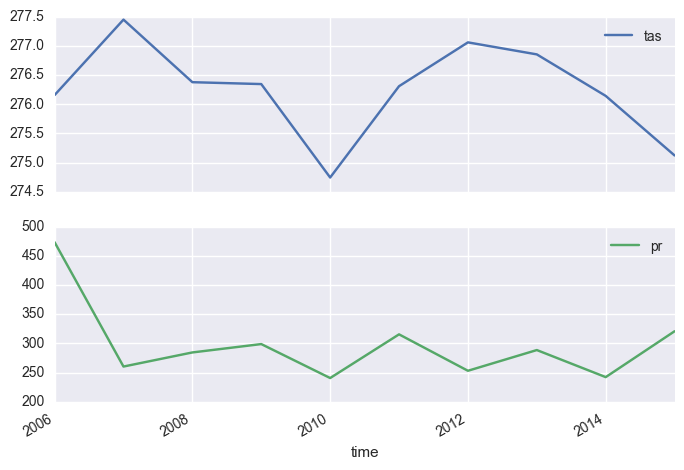

In [27]:
df = df.reset_index()[['time', 'tas', 'pr']]
df.index = df['time']
del df['time']
df.plot(subplots=True)

**Check these values look reasonable**.